In [3]:
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
library(ggrepel)
options(warn=-1)
source("../../../../src/tools.R")
source("../../../script_figures/tools.R")
library(DT)
library(mstate)
library(dplyr)
library(miceadds)

library("colorspace")
statecols <- heat_hcl(6, c = c(80, 30), l = c(30, 90),power = c(1/5, 2))[c(6,5,4,3,2,1)]
ord <- c(1,2,3,4,5,6)

In [4]:
df_nejm <- read.table("df_nejm_personnalization.tsv")
df_nejm$patient_id <- rownames(df_nejm)

df_cardiff <- read.table("df_cardiff_personnalization.tsv")
df_cardiff$patient_id <- rownames(df_cardiff)

all_gen <- colnames(df_cardiff)[c(18:101)]
all_cyto <- colnames(df_cardiff)[c(102:171)]

In [5]:
# Deal with Patients that experienced relapse and death at the same time ( we add 1 day between the 2 events)
df_nejm[,c("CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without")] <- round(df_nejm[,c("CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without")],5)

df_nejm[df_nejm$Relapse_stat==1 & df_nejm$Death_in_Relapse_stat==1 & df_nejm$Relapse==df_nejm$Death_in_Relapse ,"Death_in_Relapse"] <- df_nejm[df_nejm$Relapse_stat==1 & df_nejm$Death_in_Relapse_stat==1 &
                                                                                                                                               df_nejm$Relapse==df_nejm$Death_in_Relapse & df_nejm$Relapse==df_nejm$Death_in_Relapse,"Death_in_Relapse"] + 1/365


In [6]:
## Handle some clinical variables because not present in NEJM : perf status , secondary and ahd 

df_nejm$perf_status <- median(df_cardiff$perf_status)
df_nejm$secondary <- median(df_cardiff$secondary)
df_nejm$ahd <- median(df_cardiff$ahd)

In [7]:
comp <- c(colnames(df_cardiff)[startsWith(colnames(df_cardiff),"full_component_")],"overlap")
clin <- c("ahd","perf_status","bm_blasts","secondary","wbc","hb","plt")
demo <- c("gender","age")

cols_to_keep <- c("patient_id","CR","Relapse","Death_in_CR",
                  "Death_in_Relapse","Death_without",
                  "CR_stat","Relapse_stat","Death_in_CR_stat",
                  "Death_in_Relapse_stat","Death_without_stat",
               c("ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"))

In [8]:
# Combine Dataframes

data <- rbind(df_nejm[,cols_to_keep],df_cardiff[,cols_to_keep])
# Create Transition Matrix
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive in Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))

msdata <- msprep(data = data, trans = tmat_data, 
                 time = c(NA, "CR", "Relapse","Death_in_CR","Death_in_Relapse","Death_without"), 
                 status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),
                 keep=c("patient_id","ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"))
# Age as time dependent covariate
msdata$age <- msdata$age + msdata$Tstart

In [9]:
events(msdata)$Frequencies
events(msdata)$Proportions

                  to
from               Alive Alive in CR Alive in Relapse Death in CR
  Alive                0        2440                0           0
  Alive in CR          0           0             1364         182
  Alive in Relapse     0           0                0           0
  Death in CR          0           0                0           0
  Death in Relapse     0           0                0           0
  Death without CR     0           0                0           0
                  to
from               Death in Relapse Death without CR no event total entering
  Alive                           0              744       21           3205
  Alive in CR                     0                0      894           2440
  Alive in Relapse             1081                0      283           1364
  Death in CR                     0                0      182            182
  Death in Relapse                0                0     1081           1081
  Death without CR                

                  to
from                     Alive Alive in CR Alive in Relapse Death in CR
  Alive            0.000000000 0.761310452      0.000000000 0.000000000
  Alive in CR      0.000000000 0.000000000      0.559016393 0.074590164
  Alive in Relapse 0.000000000 0.000000000      0.000000000 0.000000000
  Death in CR      0.000000000 0.000000000      0.000000000 0.000000000
  Death in Relapse 0.000000000 0.000000000      0.000000000 0.000000000
  Death without CR 0.000000000 0.000000000      0.000000000 0.000000000
                  to
from               Death in Relapse Death without CR    no event
  Alive                 0.000000000      0.232137285 0.006552262
  Alive in CR           0.000000000      0.000000000 0.366393443
  Alive in Relapse      0.792521994      0.000000000 0.207478006
  Death in CR           0.000000000      0.000000000 1.000000000
  Death in Relapse      0.000000000      0.000000000 1.000000000
  Death without CR      0.000000000      0.000000000 1.000000000

# Prepare Coefficients plot

In [10]:
# Normalize Continuous Covariates for interpretation of the pre computed transition hazard ratio

normalized<-function(y) {

  x<-y[!is.na(y)]

  x<-(x - min(x)) / (max(x) - min(x))

  y[!is.na(y)]<-x

  return(y)
  }

set_notebook_plot_size(15,10)
msdata_precomputed <- msdata[!(msdata$trans==1 & msdata$perf_status==4),]  ### Handle perf status =4 for 2 rows in trans 1 that mess up with the ggforest because of one coefficient

msdata_precomputed$gender <- factor(msdata_precomputed$gender,labels=c("Female","Male"))
msdata_precomputed$ahd <- factor(msdata_precomputed$ahd,labels=c("no","yes"))
msdata_precomputed$perf_status <- factor(msdata_precomputed$perf_status,labels=c("Fully active","Restricted in physical activity","capable of selfcare but no work activities","limited selfcare","completely disabled"))
msdata_precomputed$secondary <- factor(msdata_precomputed$secondary,labels=c(1,2,3))
# msdata_precomputed[,c("secondary")] <- lapply(msdata_precomputed[,c("secondary")],as.factor)


msdata_precomputed[,c("age","bm_blasts","wbc","hb","plt")] <- apply(msdata_precomputed[,c("age","bm_blasts","wbc","hb","plt")],2,normalized)
# msdata_precomputed[,c(clin,demo)] <- apply(msdata_precomputed[,c(clin,demo)],2,normalized)
covariates <- c(demo,clin,comp[comp!="overlap"],"ITD","NEW_favorable","NEW_adverse","NEW_intermediate")
form <- "Surv(Tstart, Tstop, status) ~ "
for (co in c(covariates)){
    form <- paste (form,co,sep = " + ")
}
data_trans <- list()
cox_trans <- list()
plot_forest <- list()
for (i in c(1:5)){
    data_trans[[i]] <- msdata_precomputed[msdata_precomputed$trans==i,]
    formula <- ifelse(i!=4,form,gsub("full_component_t_15_17 \\+","",form))   ## Handle comp t(15,17) for trans 4 because otherwise ggforest do not work!
    cox_trans[[i]] <- coxph(as.formula(formula), data = data_trans[[i]], method = "breslow")
    title <- ifelse(i==1,"Alive --> Alive in CR",
                   ifelse(i==2,"Alive --> Death Without CR",
                         ifelse(i==3,"Alive in CR -->Alive with Relapse",
                               ifelse(i==4,"Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    plot_forest[[i]] <- ggforest(cox_trans[[i]],main=paste("Hazard ratio for ",title),fontsize=1)
}

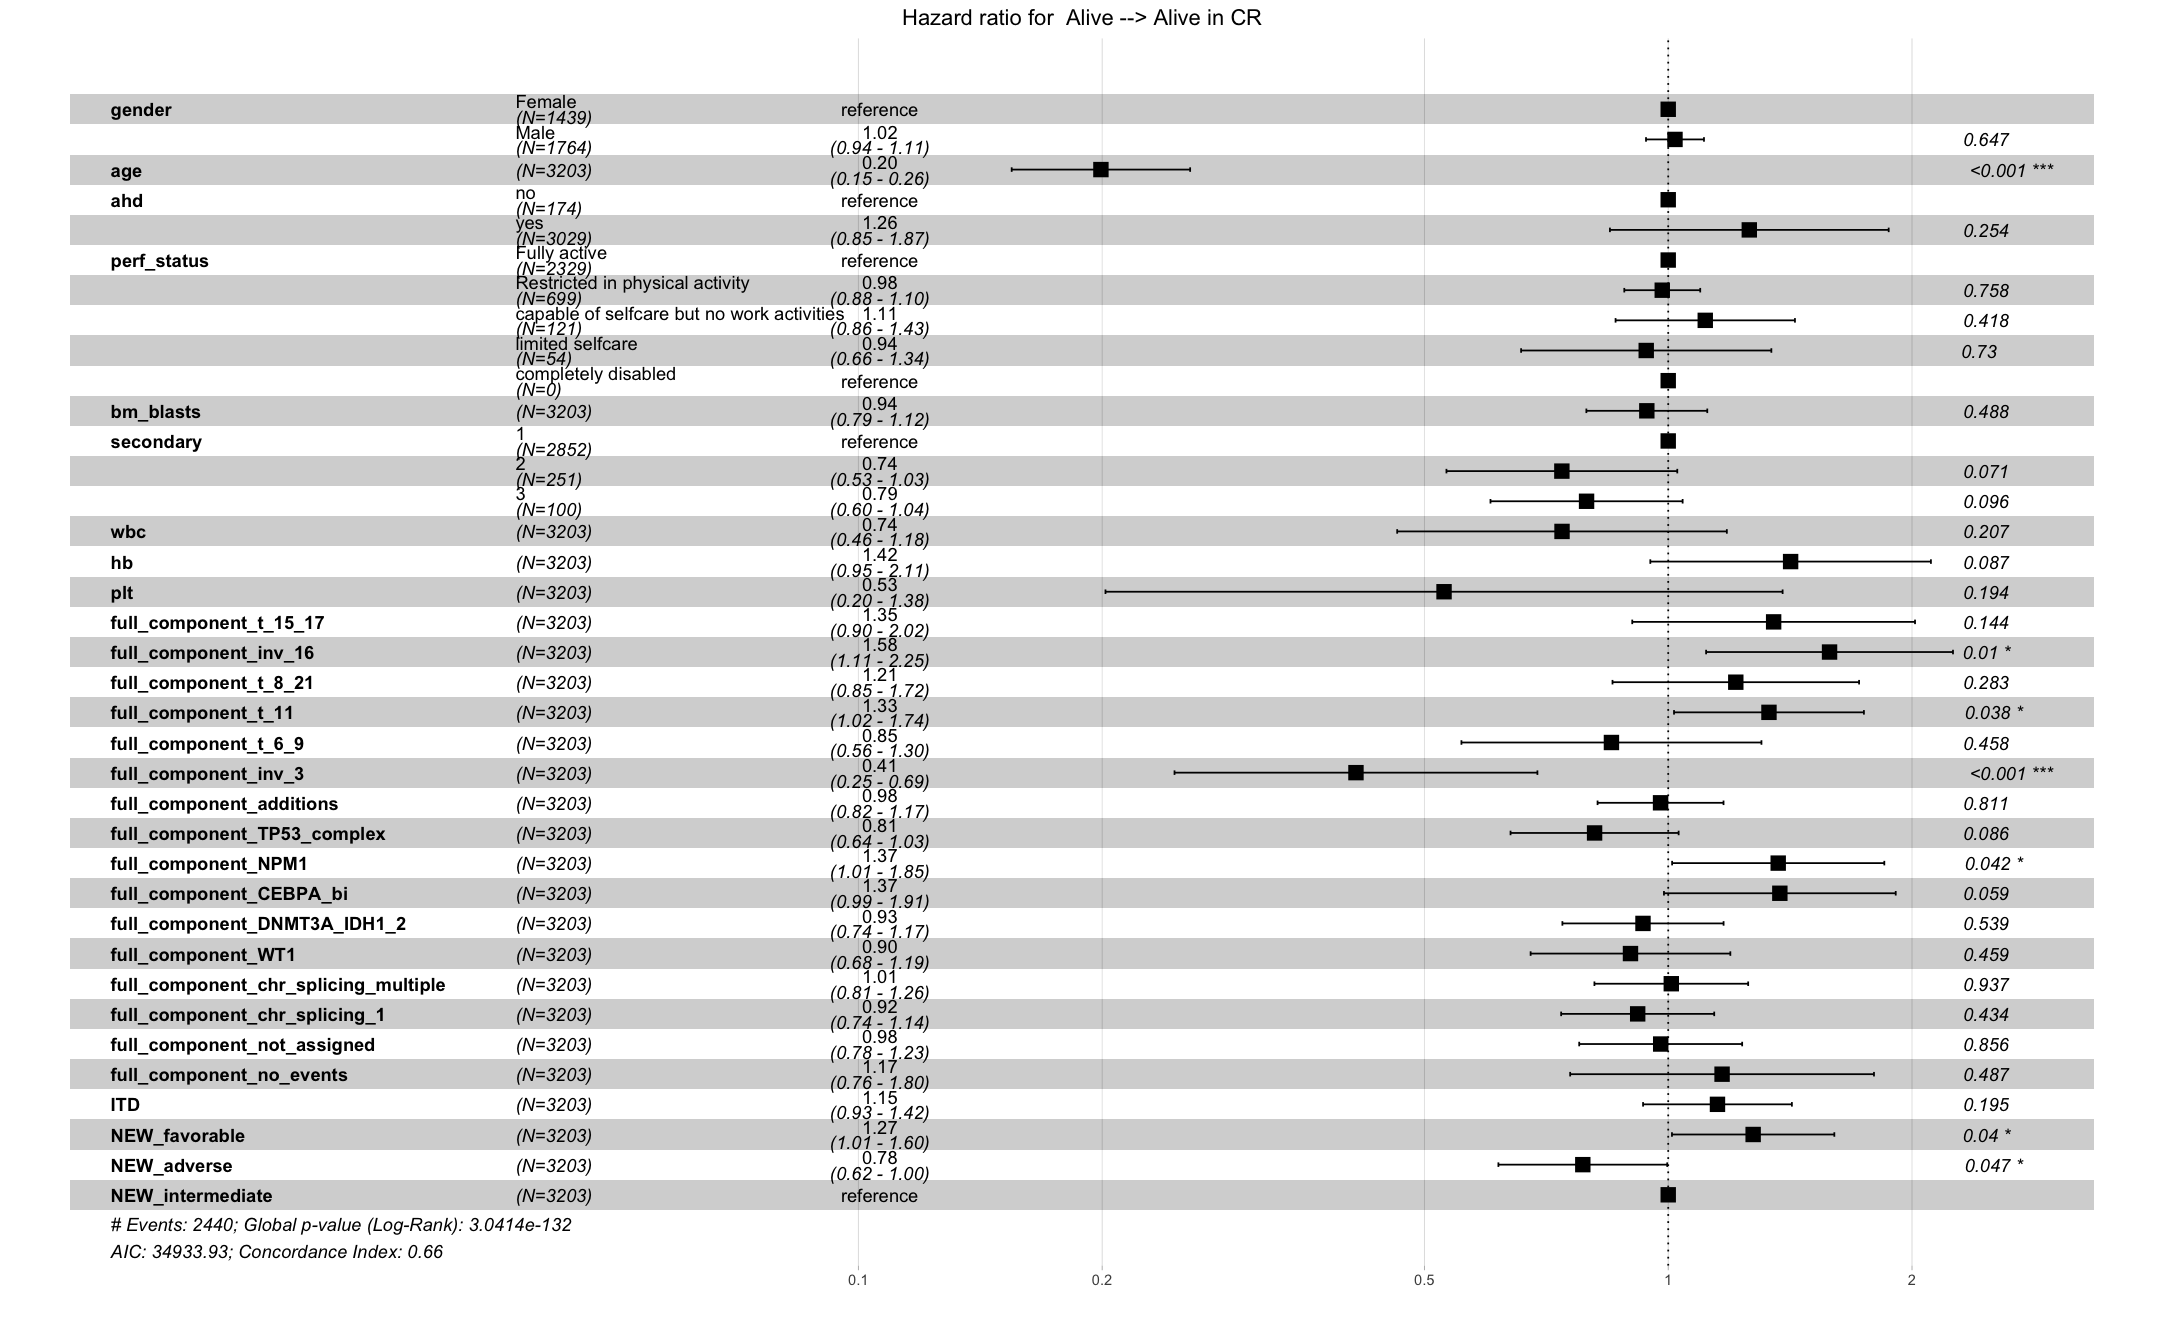

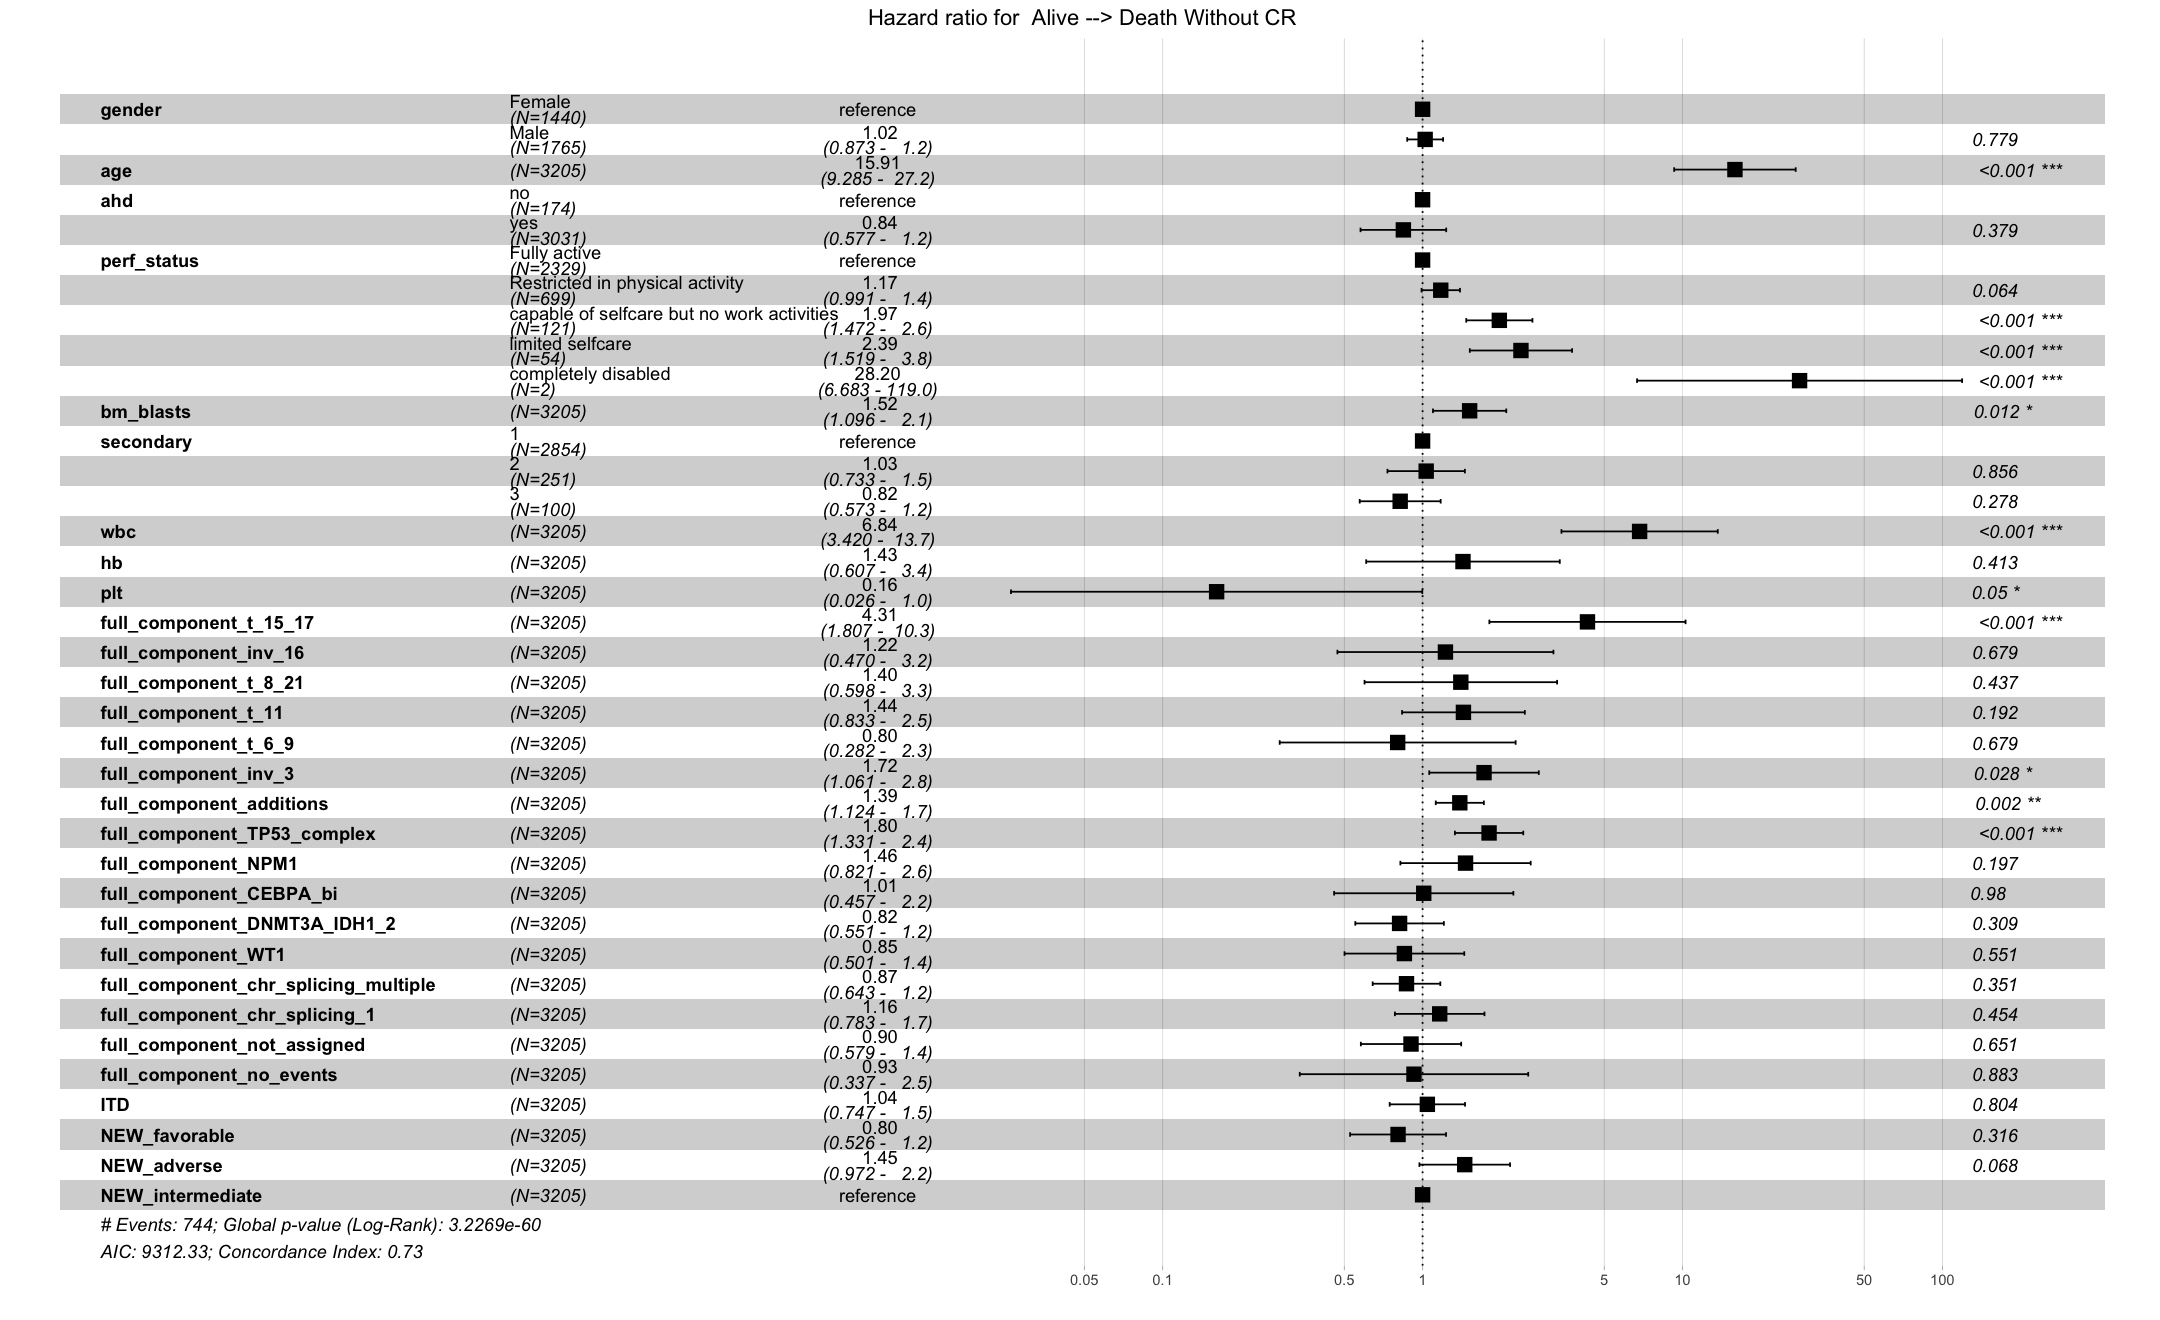

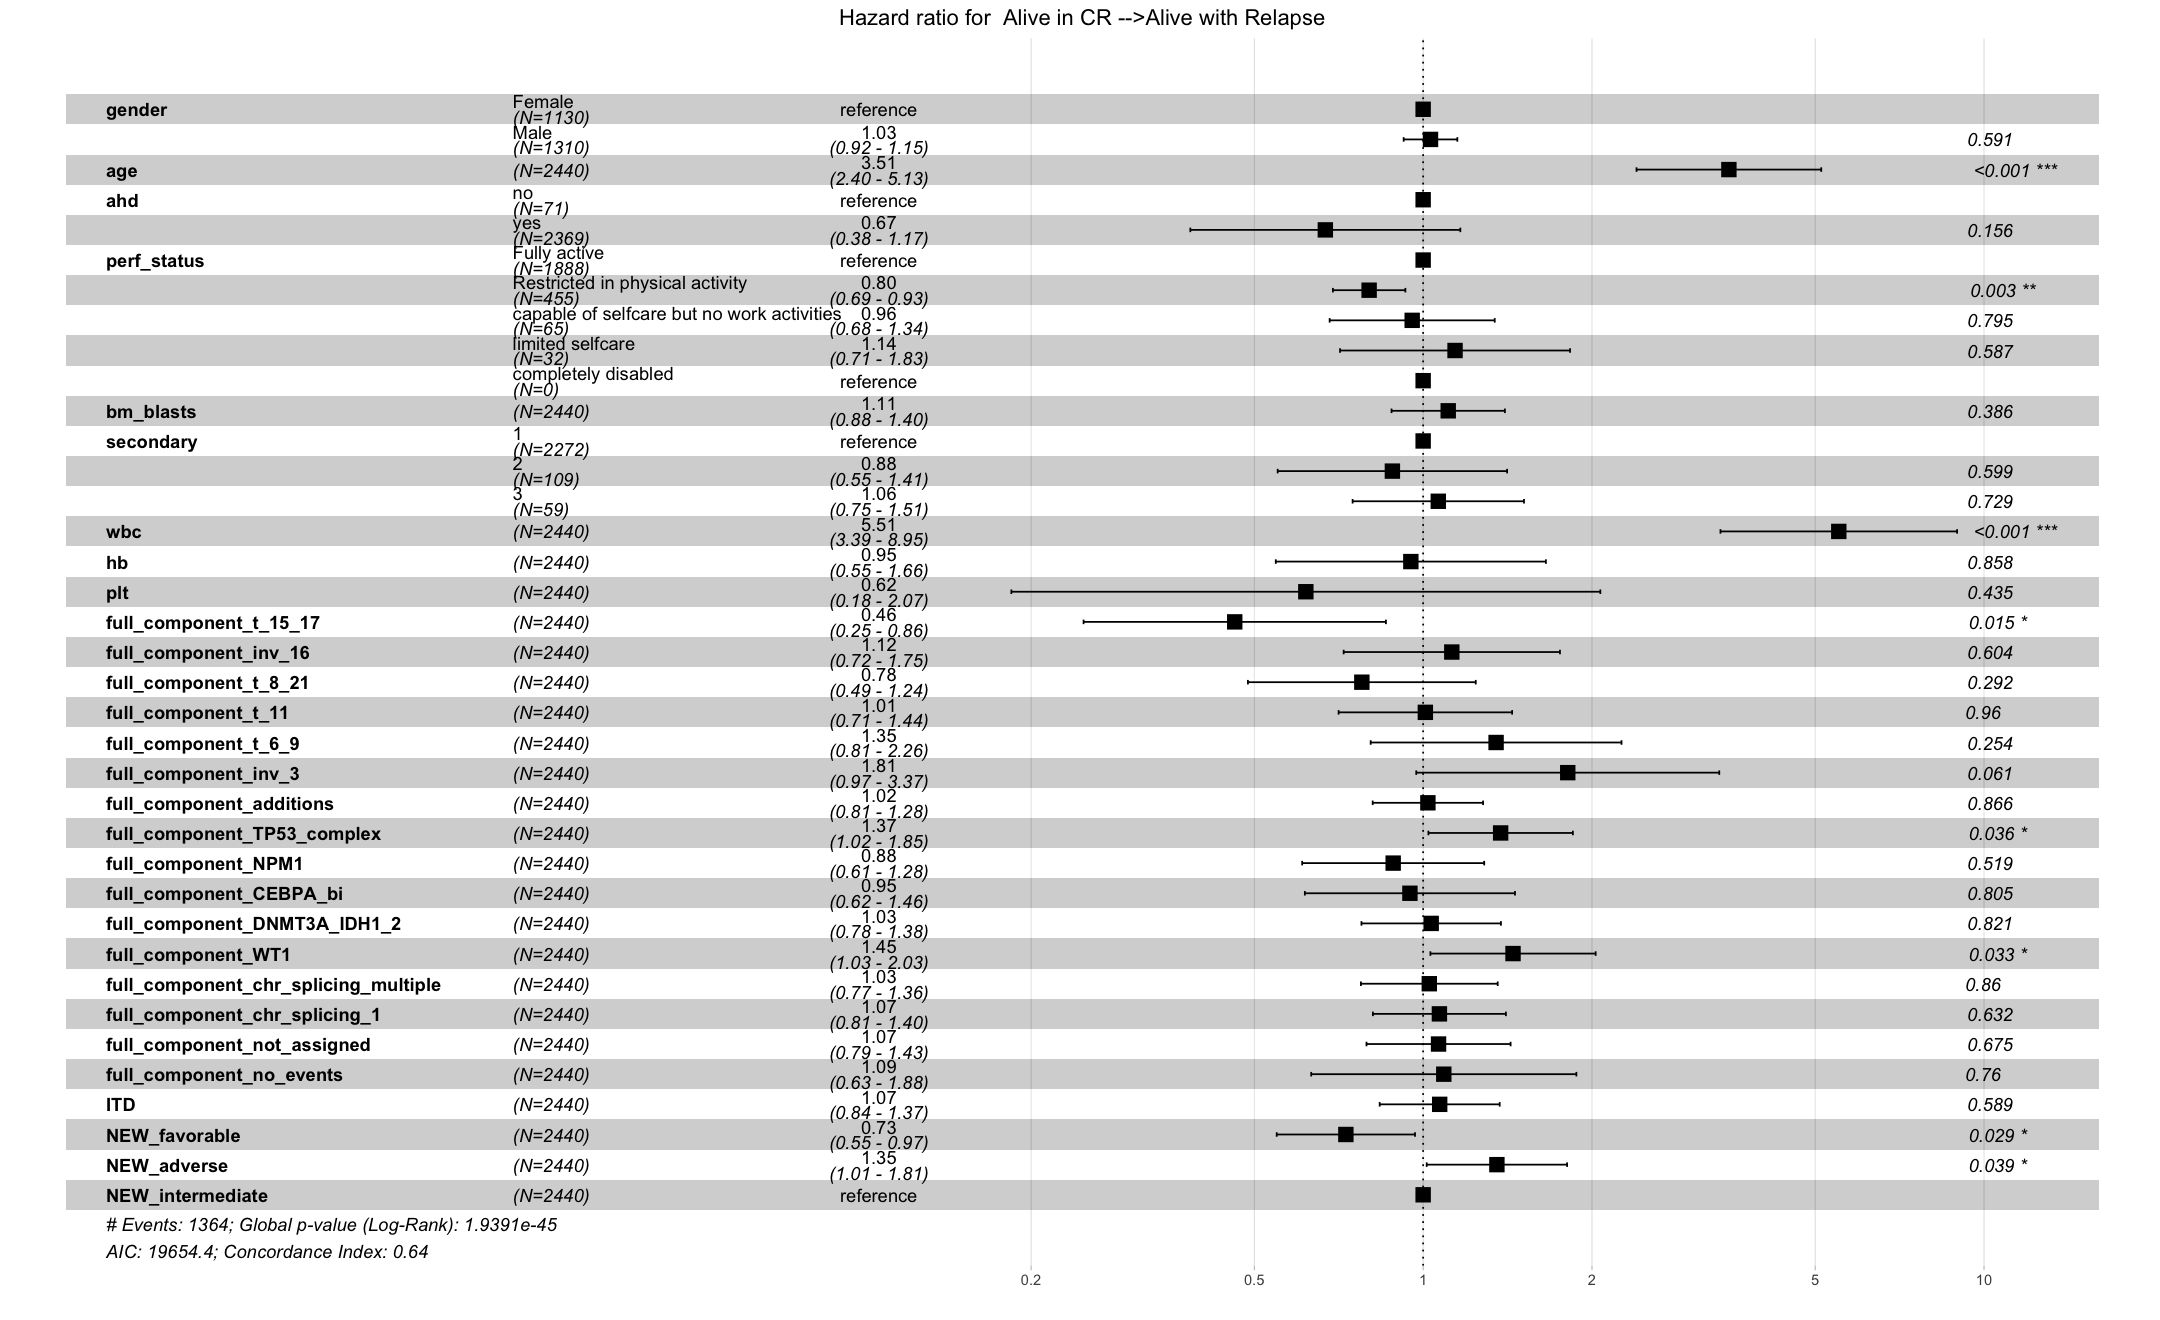

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


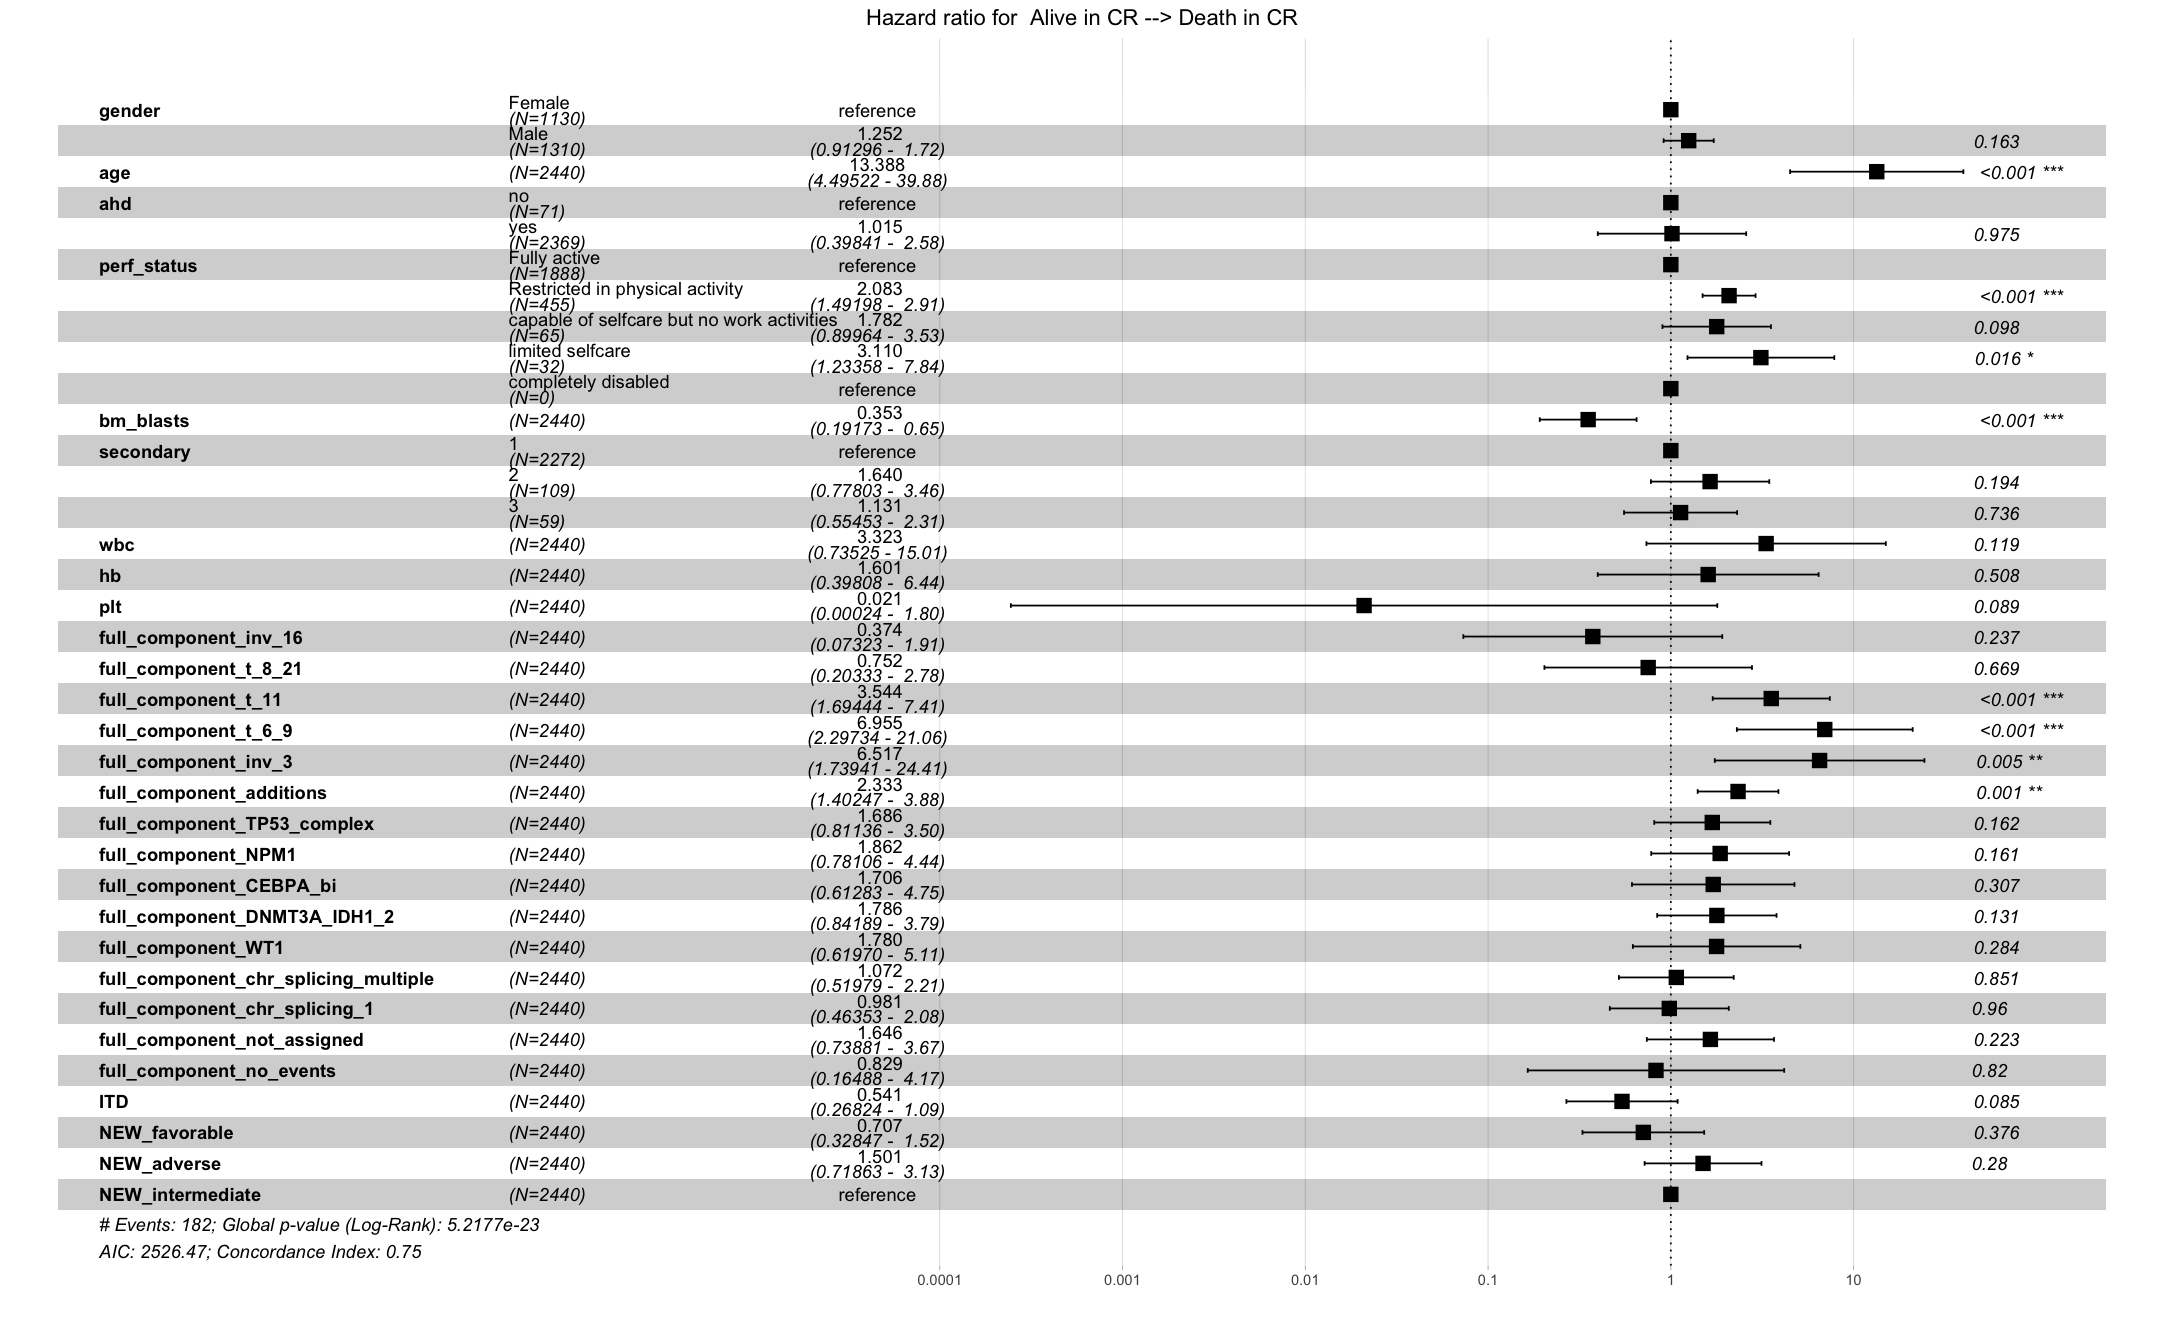

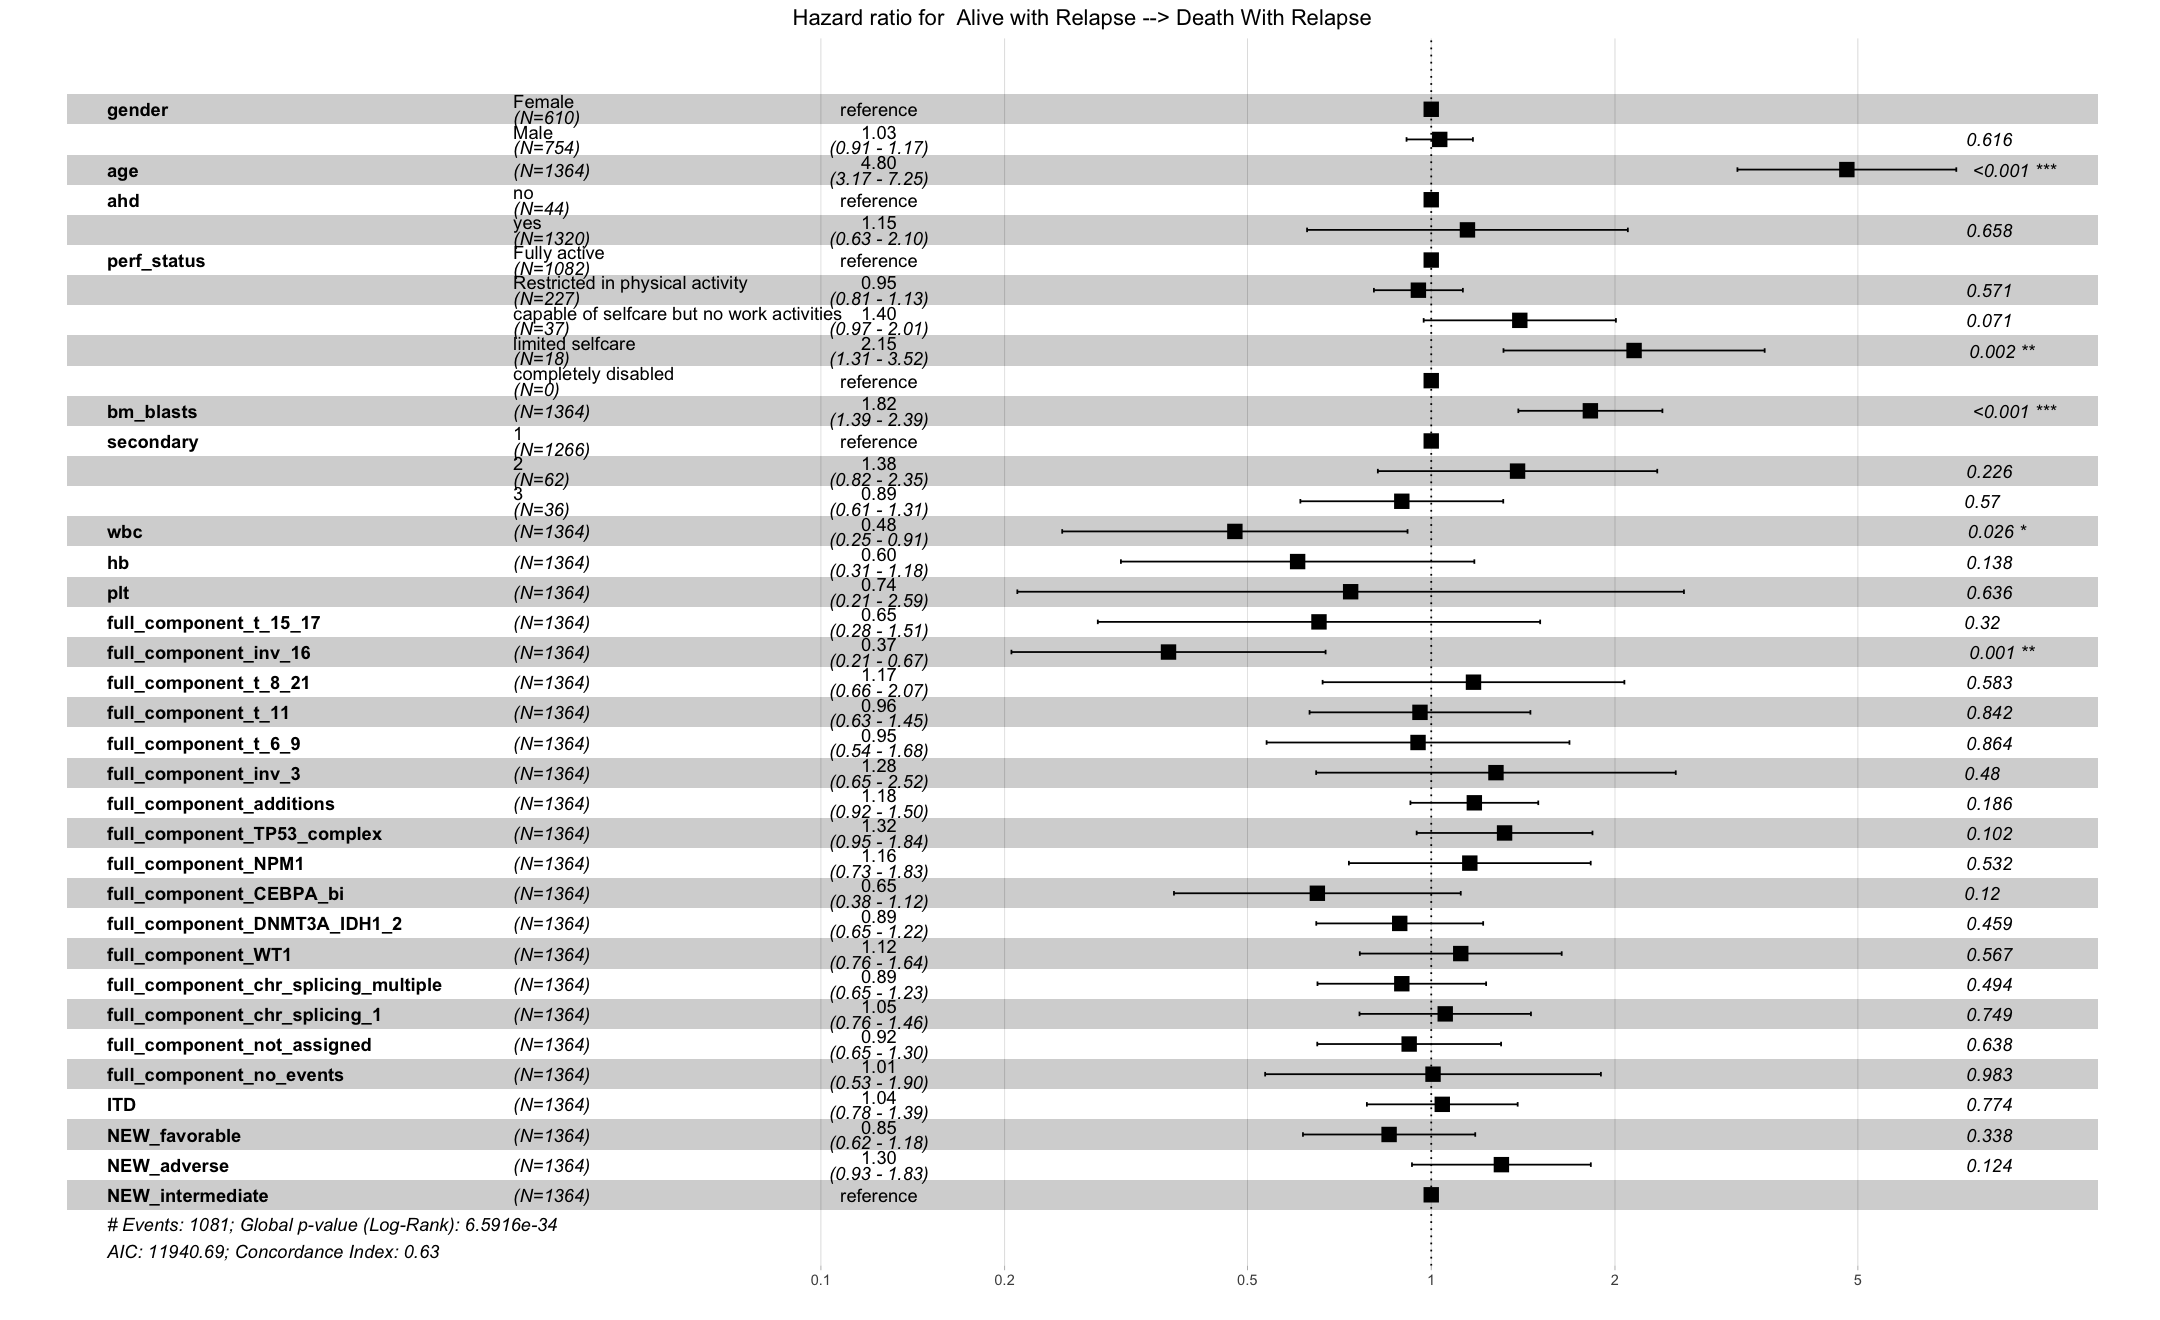

In [263]:
set_notebook_plot_size(18,11)
plot_forest

In [259]:
pdf("Output_patient/Page3.pdf",width=20,height=20)
plot_forest
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


pdf 
  2

# Prepare the Model for computation and patient-centric inference

In [11]:
msdata <- expand.covs(msdata, covs = c("ITD",comp,clin,demo,"NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
expanded_itd <- colnames(msdata)[40:44]
expanded_component <- colnames(msdata)[45:129]
expanded_clin <- colnames(msdata)[130:164]
expanded_demo <- colnames(msdata)[165:174]
expanded_proposal <- colnames(msdata)[175:189]

In [12]:
# Prepare Full Model
covariates <- c(demo,clin,comp[comp!="overlap"],"ITD","NEW_favorable","NEW_adverse","NEW_intermediate")
form <- "Surv(Tstart, Tstop, status) ~ "
for (co in c(covariates)){
    
    for (sub in c(".1",".2",".3",".4",".5")){
        form <- paste (form,paste(co,sub,sep=""),sep = " + ")
    }
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")

In [13]:
# Prepare Proposal Model
form <- "Surv(Tstart, Tstop, status) ~ "
for (co in expanded_proposal){
        form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull_proposal <- coxph(as.formula(form), data = msdata, method = "breslow")

In [14]:
### Get Covariates median from msdata
covariates_median <- sapply(msdata[,c(clin,demo)], FUN=median,)
t(covariates_median)

ahd perf_status bm_blasts secondary wbc  hb       plt gender age     
[1,] 1   0           69        1         16.8 9.299995 57  1      54.05753

# A function for Component and Proposal Classification 

In [15]:
classify_components <- function(user_data,keep=c(demo,clin,comp,"ITD"),proposal=T){
    factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
    
    user_data["full_component_t_15_17","value"] <- ifelse(user_data["t_15_17","value"]==1,1,0)
    
    user_data["full_component_inv_16","value"] <- ifelse(user_data["inv_16","value"]==1,1,0)
    
    user_data["full_component_t_8_21","value"] <- ifelse(user_data["t_8_21","value"]==1,1,0) 
    
    user_data["full_component_t_11","value"] <- ifelse((user_data["t_v_11","value"]==1 | user_data["t_9_11","value"]==1),1,0)   
    
    user_data["full_component_t_6_9","value"] <- ifelse(user_data["t_6_9","value"]==1,1,0) 
    
    user_data["full_component_inv_3","value"] <- ifelse(user_data["inv_3","value"]==1,1,0)
    
    user_data["full_component_additions","value"] <- ifelse((user_data["add_8","value"]==1 | user_data["add_11","value"]==1 |
                                                             user_data["add_13","value"]==1 | user_data["add_21","value"]==1 |
                                                             user_data["add_22","value"]==1),1,0)
    
    user_data["full_component_TP53_complex","value"] <- ifelse((user_data["TP53","value"]==1 | user_data["complex","value"]==1) ,1,0)
    
    user_data["full_component_NPM1","value"] <- ifelse(user_data["NPM1","value"]==1,1,0) 
    
    user_data["full_component_CEBPA_bi","value"] <- ifelse(user_data["CEBPA_bi","value"]==1,1,0) 
    
    user_data["full_component_DNMT3A_IDH1_2","value"] <- ifelse((user_data["DNMT3A","value"]==1 & (user_data["IDH1","value"]==1 | user_data["IDH2_p.R140","value"]==1 | user_data["IDH2_p.R172","value"]==1)),1,0)
    
    user_data["full_component_WT1","value"] <- ifelse(user_data["WT1","value"]==1,1,0) 
    
    user_data["full_component_chr_splicing_multiple","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)>1 ,1,0)
    
    user_data["full_component_chr_splicing_1","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)==1,1,0)
    
    user_data["overlap","value"] <- ifelse(sum(user_data[comp,"value"],na.rm=T) >1 ,1,0)
    
    user_data["full_component_not_assigned","value"] <- ifelse((sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)>0 & sum(user_data[comp,"value"],na.rm=T)==0),1,0)
    
    user_data["full_component_no_events","value"] <- ifelse(sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)==0 ,1,0)    
    
    if (proposal==T){
        
        user_data[c("NEW_favorable","NEW_intermediate","NEW_adverse"),"value"] <- 0
        
        
        user_data["NEW_favorable","value"] <- ifelse((sum(user_data[c("full_component_NPM1","full_component_no_events","full_component_inv_16","full_component_t_8_21","full_component_t_15_17"),"value"],na.rm=T)>=1 |
                                                      (user_data["full_component_additions","value"]==1 & user_data["overlap","value"]==0)),1,0)
        
        user_data["NEW_intermediate","value"] <- ifelse(((user_data["full_component_chr_splicing_1","value"]==1 | user_data["full_component_not_assigned","value"]==1) &  user_data["NEW_favorable","value"]==0) ,1,0 )

        user_data["NEW_adverse","value"] <- ifelse(((user_data["full_component_additions","value"]==1 | user_data["full_component_TP53_complex","value"]==1 |
                                                    user_data["full_component_chr_splicing_multiple","value"]==1 | user_data["full_component_inv_3","value"]==1) &
                                                    (user_data["NEW_favorable","value"]==0 & user_data["NEW_intermediate","value"]==0)) ,1,0)
        
        user_data["NEW_favorable","value"] <- ifelse(user_data["full_component_CEBPA_bi","value"]==1 & user_data["NEW_intermediate","value"]==0 & user_data["NEW_adverse","value"]==0,1,user_data["NEW_favorable","value"])
     
        user_data["NEW_intermediate","value"] <- ifelse(((user_data["full_component_t_11","value"]==1 | user_data["full_component_t_6_9","value"]==1 |
                                                         user_data["full_component_WT1","value"]==1 | user_data["full_component_DNMT3A_IDH1_2","value"]==1) &
                                                         (user_data["NEW_favorable","value"]==0 & user_data["NEW_adverse","value"]==0)),1,user_data["NEW_intermediate","value"])

        #order is important! adverse . then intermediate otherwise we . overlap
        
        user_data["NEW_adverse","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,1,user_data["NEW_adverse","value"] )
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_intermediate","value"])
        
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,1,user_data["NEW_intermediate","value"] )
        user_data["NEW_favorable","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_favorable","value"])

        return(user_data[c(keep,"NEW_favorable","NEW_intermediate","NEW_adverse"),,drop=F])
        
    }else{
        return(user_data[keep,,drop=F])
        }

}

In [16]:
#### VIP : Don't forget to add the rules for additions, DNMT3A IDH ,WT1 and splicing 1
classify_components <- function(user_data,keep=c(demo,clin,comp,"ITD"),proposal=T){
    factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
    
    user_data["full_component_t_15_17","value"] <- ifelse(user_data["t_15_17","value"]==1,1,0)
    
    user_data["full_component_inv_16","value"] <- ifelse(user_data["inv_16","value"]==1,1,0)
    
    user_data["full_component_t_8_21","value"] <- ifelse(user_data["t_8_21","value"]==1,1,0) 
    
    user_data["full_component_t_11","value"] <- ifelse((user_data["t_v_11","value"]==1 | user_data["t_9_11","value"]==1),1,0)   
    
    user_data["full_component_t_6_9","value"] <- ifelse(user_data["t_6_9","value"]==1,1,0) 
    
    user_data["full_component_inv_3","value"] <- ifelse(user_data["inv_3","value"]==1,1,0)
    
    user_data["full_component_additions","value"] <- ifelse((user_data["add_8","value"]==1 | user_data["add_11","value"]==1 |
                                                             user_data["add_13","value"]==1 | user_data["add_21","value"]==1 |
                                                             user_data["add_22","value"]==1),1,0)
    
    user_data["full_component_TP53_complex","value"] <- ifelse((user_data["TP53","value"]==1 | user_data["complex","value"]==1) ,1,0)
    
    user_data["full_component_NPM1","value"] <- ifelse(user_data["NPM1","value"]==1,1,0) 
    
    user_data["full_component_CEBPA_bi","value"] <- ifelse(user_data["CEBPA_bi","value"]==1,1,0) 
    
    user_data["full_component_DNMT3A_IDH1_2","value"] <- ifelse((user_data["DNMT3A","value"]==1 & (user_data["IDH1","value"]==1 | user_data["IDH2_p.R140","value"]==1 | user_data["IDH2_p.R172","value"]==1)),1,0)
    
    user_data["full_component_WT1","value"] <- ifelse(user_data["WT1","value"]==1,1,0) 
    
    user_data["full_component_chr_splicing_multiple","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)>1 ,1,0)
    
    user_data["full_component_chr_splicing_1","value"] <- ifelse(sum(user_data[factors,"value"],na.rm=T)==1,1,0)
    
    user_data["full_component_not_assigned","value"] <- ifelse((sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)>0 & sum(user_data[comp,"value"],na.rm=T)==0),1,0)
    
    user_data["full_component_no_events","value"] <- ifelse(sum(user_data[c(all_gen,all_cyto),"value"],na.rm=T)==0 ,1,0)    
    
    user_data["full_component_additions","value"] <- ifelse(sum(user_data[c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_t_11","full_component_t_6_9","full_component_inv_3",
                                                                           "full_component_NPM1","full_component_CEBPA_bi","full_component_DNMT3A_IDH1_2","full_component_WT1"),"value"],na.rm=T)>=1,0,user_data["full_component_additions","value"])
    
    user_data["full_component_additions","value"] <- ifelse(user_data["full_component_TP53_complex","value"]==1 & 
                                                            (sum(user_data[c("del_7","del_17","del_5","del_9","del_13","del_20","del_18","del_16","del_12","del_3","minusy"),"value"],na.rm=T)==0) ,0,user_data["full_component_additions","value"])
    
    user_data["full_component_DNMT3A_IDH1_2","value"] <- ifelse(sum(user_data[c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_t_11","full_component_t_6_9","full_component_inv_3","full_component_TP53_complex",
                                                                           "full_component_NPM1","full_component_CEBPA_bi","full_component_additions"),"value"],na.rm=T)>=1,0,user_data["full_component_DNMT3A_IDH1_2","value"])
    
    user_data["full_component_WT1","value"] <- ifelse(sum(user_data[c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_t_11","full_component_t_6_9","full_component_inv_3","full_component_TP53_complex",
                                                                           "full_component_NPM1","full_component_CEBPA_bi"),"value"],na.rm=T)>=1,0,user_data["full_component_WT1","value"])
    
    user_data["full_component_chr_splicing_1","value"] <- ifelse(sum(user_data[c("full_component_t_15_17","full_component_inv_16","full_component_t_8_21","full_component_t_11","full_component_t_6_9","full_component_inv_3","full_component_TP53_complex",
                                                                           "full_component_NPM1","full_component_CEBPA_bi"),"value"],na.rm=T)>=1,0,user_data["full_component_chr_splicing_1","value"])
    
    user_data["overlap","value"] <- ifelse(sum(user_data[comp,"value"],na.rm=T) >1 ,1,0)
    
    if (proposal==T){
        
        user_data[c("NEW_favorable","NEW_intermediate","NEW_adverse"),"value"] <- 0
        
        
        user_data["NEW_favorable","value"] <- ifelse((sum(user_data[c("full_component_NPM1","full_component_inv_16","full_component_t_8_21","full_component_t_15_17"),"value"],na.rm=T)>=1),1,0)
        
        user_data["NEW_intermediate","value"] <- ifelse(((user_data["full_component_chr_splicing_1","value"]==1 | user_data["full_component_t_6_9","value"]==1) &  user_data["NEW_favorable","value"]==0) ,1,0 )

        user_data["NEW_adverse","value"] <- ifelse((((user_data["full_component_additions","value"]==1 & user_data["overlap","value"]==1) | user_data["full_component_chr_splicing_multiple","value"]==1 |
                                                     user_data["full_component_TP53_complex","value"]==1 | user_data["full_component_inv_3","value"]==1) &
                                                    (user_data["NEW_favorable","value"]==0 & user_data["NEW_intermediate","value"]==0)) ,1,0)
        
        user_data["NEW_intermediate","value"] <- ifelse((((user_data["full_component_additions","value"]==1 & user_data["overlap","value"]==0) | user_data["full_component_t_11","value"]==1 |
                                                         user_data["full_component_WT1","value"]==1 | user_data["full_component_DNMT3A_IDH1_2","value"]==1 | user_data["full_component_not_assigned","value"]==1) &
                                                         (user_data["NEW_favorable","value"]==0 & user_data["NEW_adverse","value"]==0)),1,user_data["NEW_intermediate","value"])
        
        user_data["NEW_favorable","value"] <- ifelse((user_data["full_component_CEBPA_bi","value"]==1 | user_data["full_component_no_events","value"]==1) &
                                                     user_data["NEW_intermediate","value"]==0 & user_data["NEW_adverse","value"]==0,1,user_data["NEW_favorable","value"])
     
        

        #order is important! adverse . then intermediate otherwise we . overlap
        
        user_data["NEW_adverse","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,1,user_data["NEW_adverse","value"] )
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_intermediate","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_intermediate","value"])
        
        user_data["NEW_intermediate","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,1,user_data["NEW_intermediate","value"] )
        user_data["NEW_favorable","value"] <- ifelse(user_data["NEW_favorable","value"]==1 & user_data["ITD","value"]==1 ,0,user_data["NEW_favorable","value"])

        return(user_data[c(keep,"NEW_favorable","NEW_intermediate","NEW_adverse"),,drop=F])
        
    }else{
        return(user_data[keep,,drop=F])
        }

}

# III) Tutorial for  personalized outcome

# User specification 

# Empty Dataframe with Covariates : Gen, Cyto , Clin , Demo

In [34]:
user_data <- data.frame(covariates = c(demo,clin,all_gen,all_cyto))
user_data$value <- "Not specified"
rownames(user_data) <- user_data$covariates
user_data$covariates <- NULL
datatable(user_data,options= list(pageLength = 10))

HTML widgets cannot be represented in plain text (need html)

# User specifies the Covariates


In [35]:
change_covariates <- list(age=80,NPM1=1,ITD=1)

In [36]:
user_data[names(change_covariates),"value"] <- as.vector(unlist(change_covariates))
datatable(user_data,options= list(pageLength= 10))

HTML widgets cannot be represented in plain text (need html)

# Handle Not Specified Values 

In [37]:
user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(all_gen,all_cyto) ,"value"] <- 0
user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(clin,demo) ,"value"] <- covariates_median[rownames(user_data)[user_data$value=="Not specified"]]

user_data$value <- as.numeric(user_data$value)  ### make sure values are numeric!

datatable(user_data,options= list(pageLength= 10))



HTML widgets cannot be represented in plain text (need html)

# Data Reduction : Conversion to a Component driven dataframe with clinic and demographic information

In [38]:
datatable(classify_components(user_data,proposal=T),options= list(pageLength= 50))

HTML widgets cannot be represented in plain text (need html)

# Plots

# 1) Main Plots

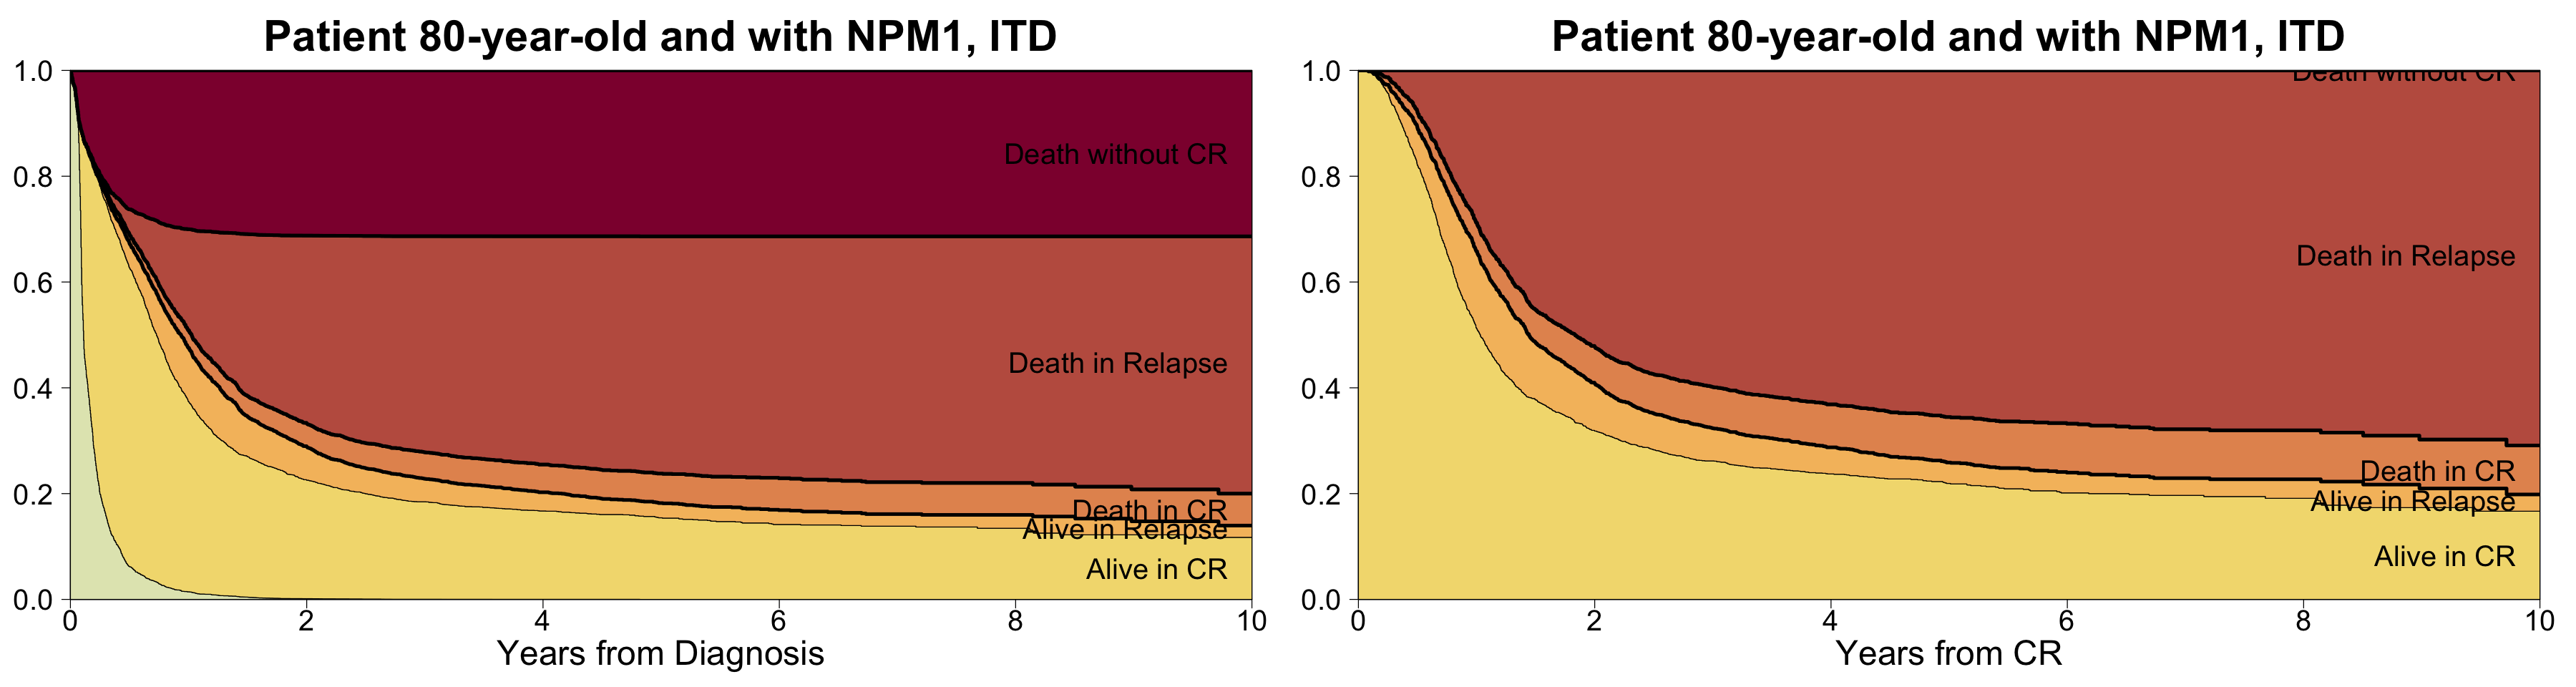

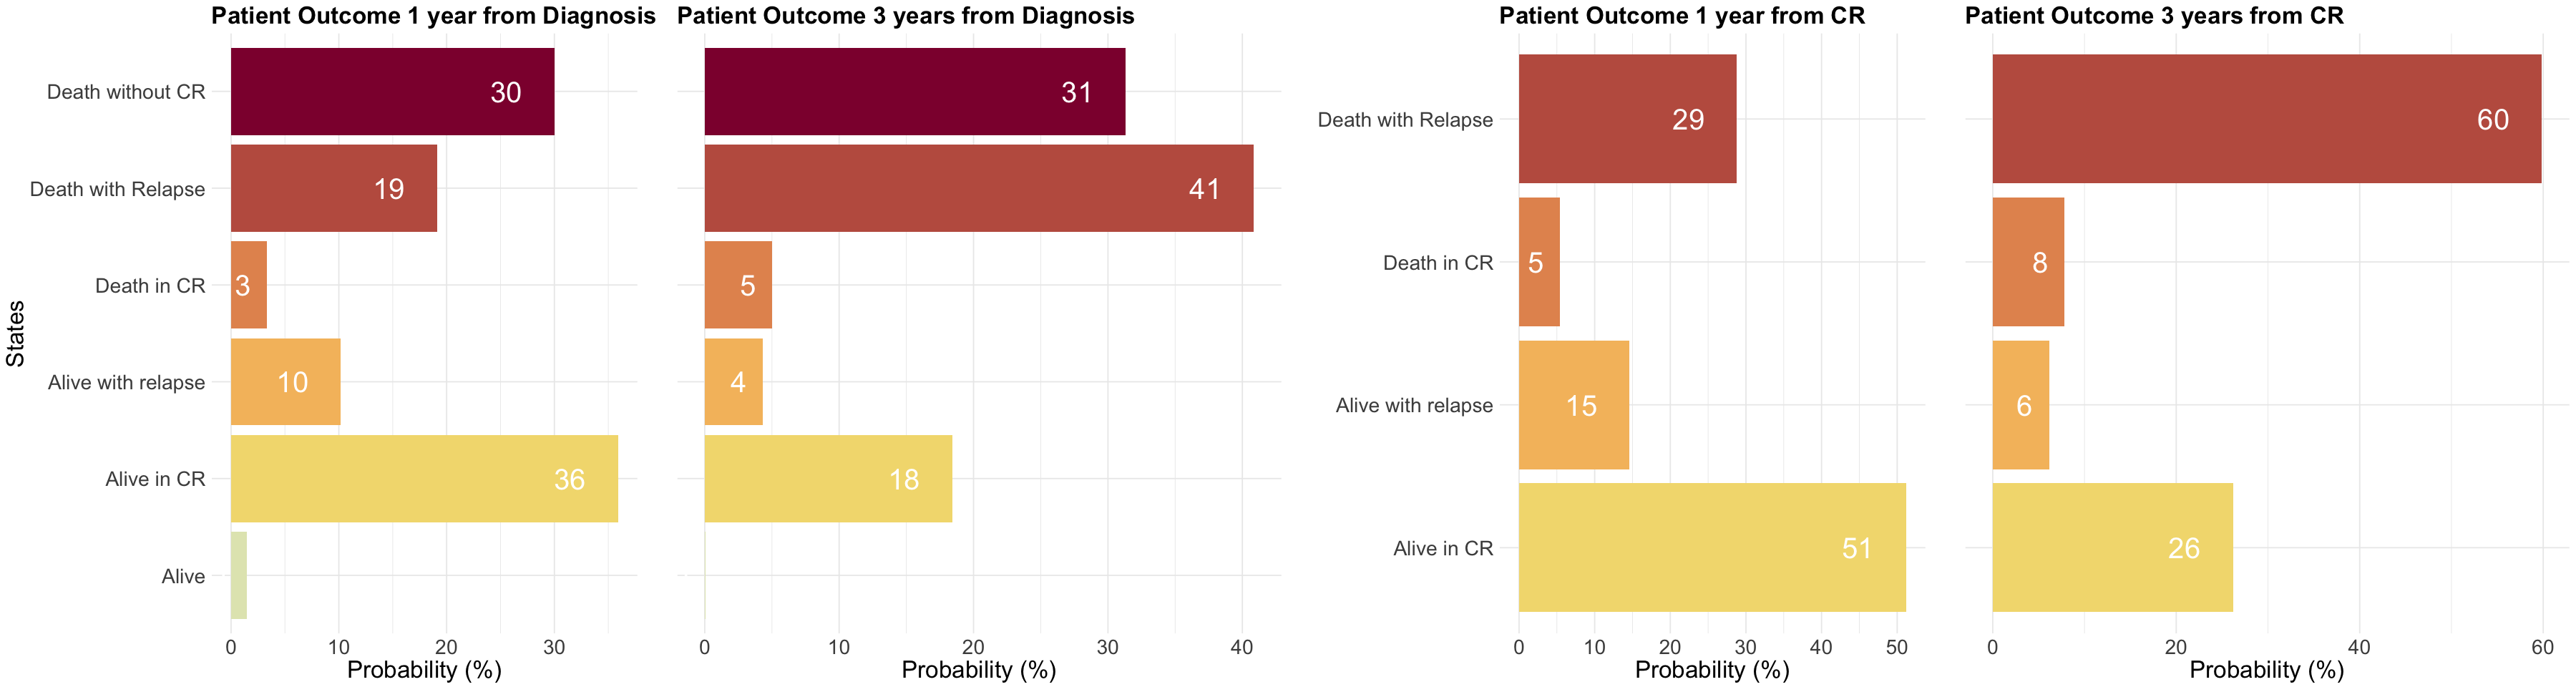

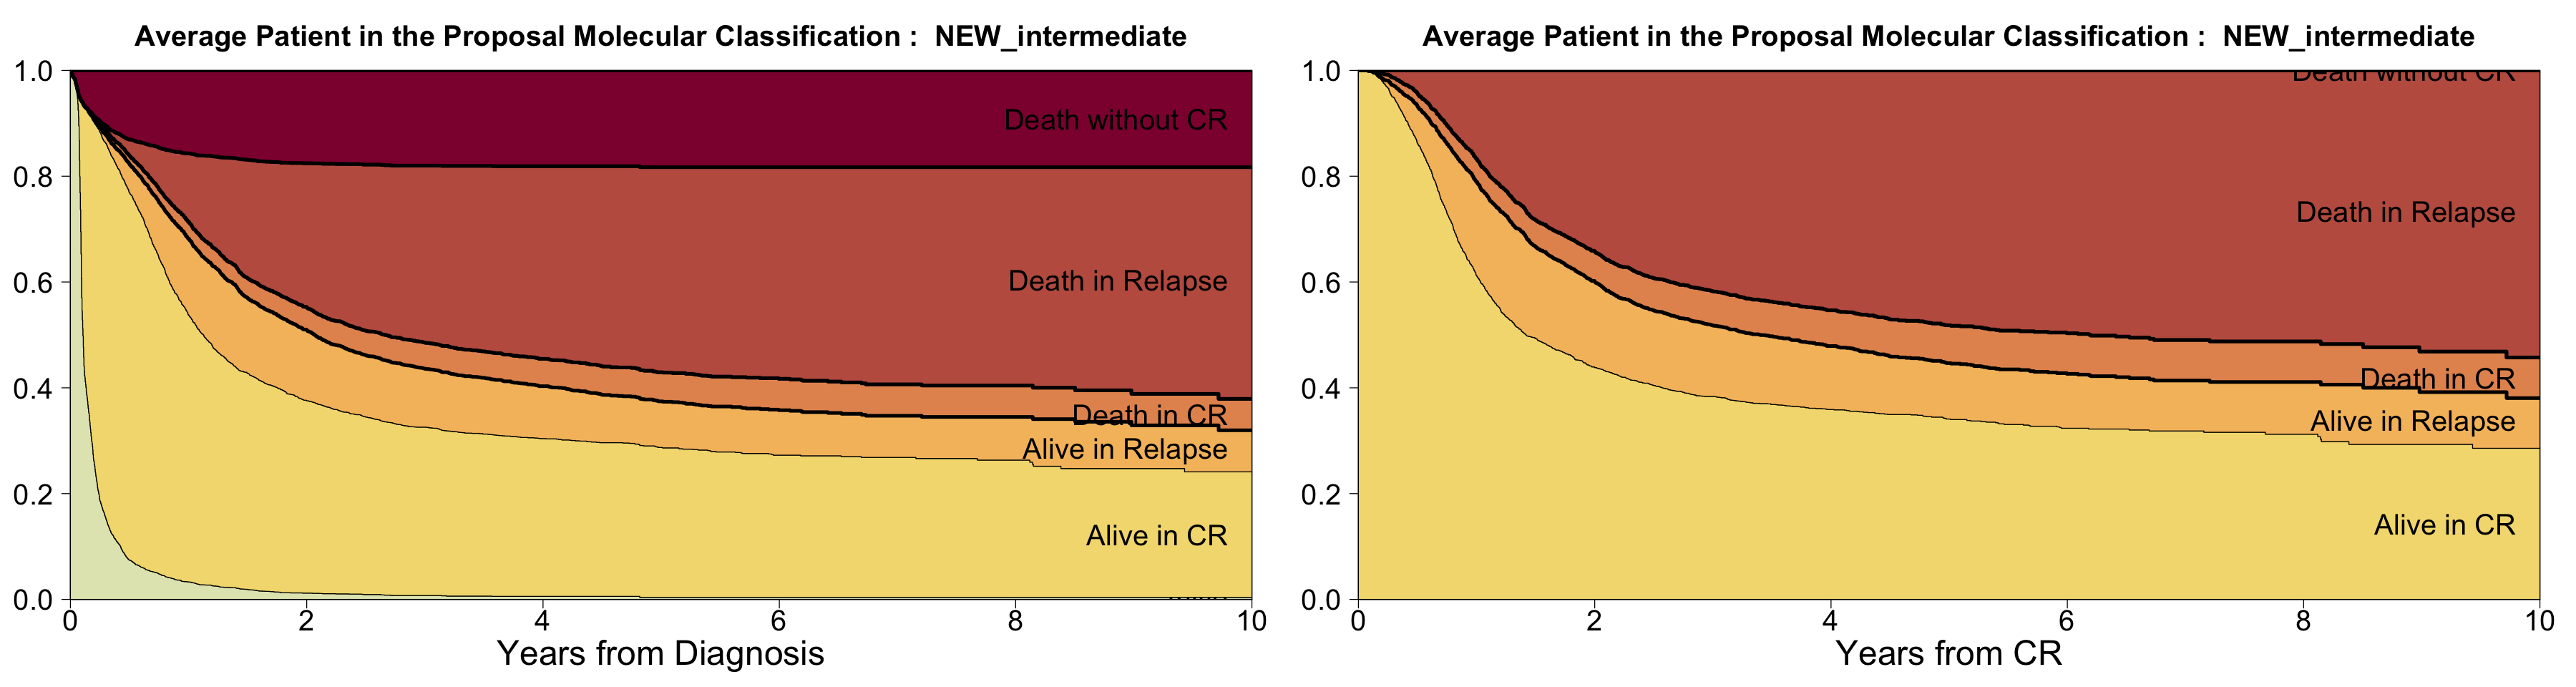

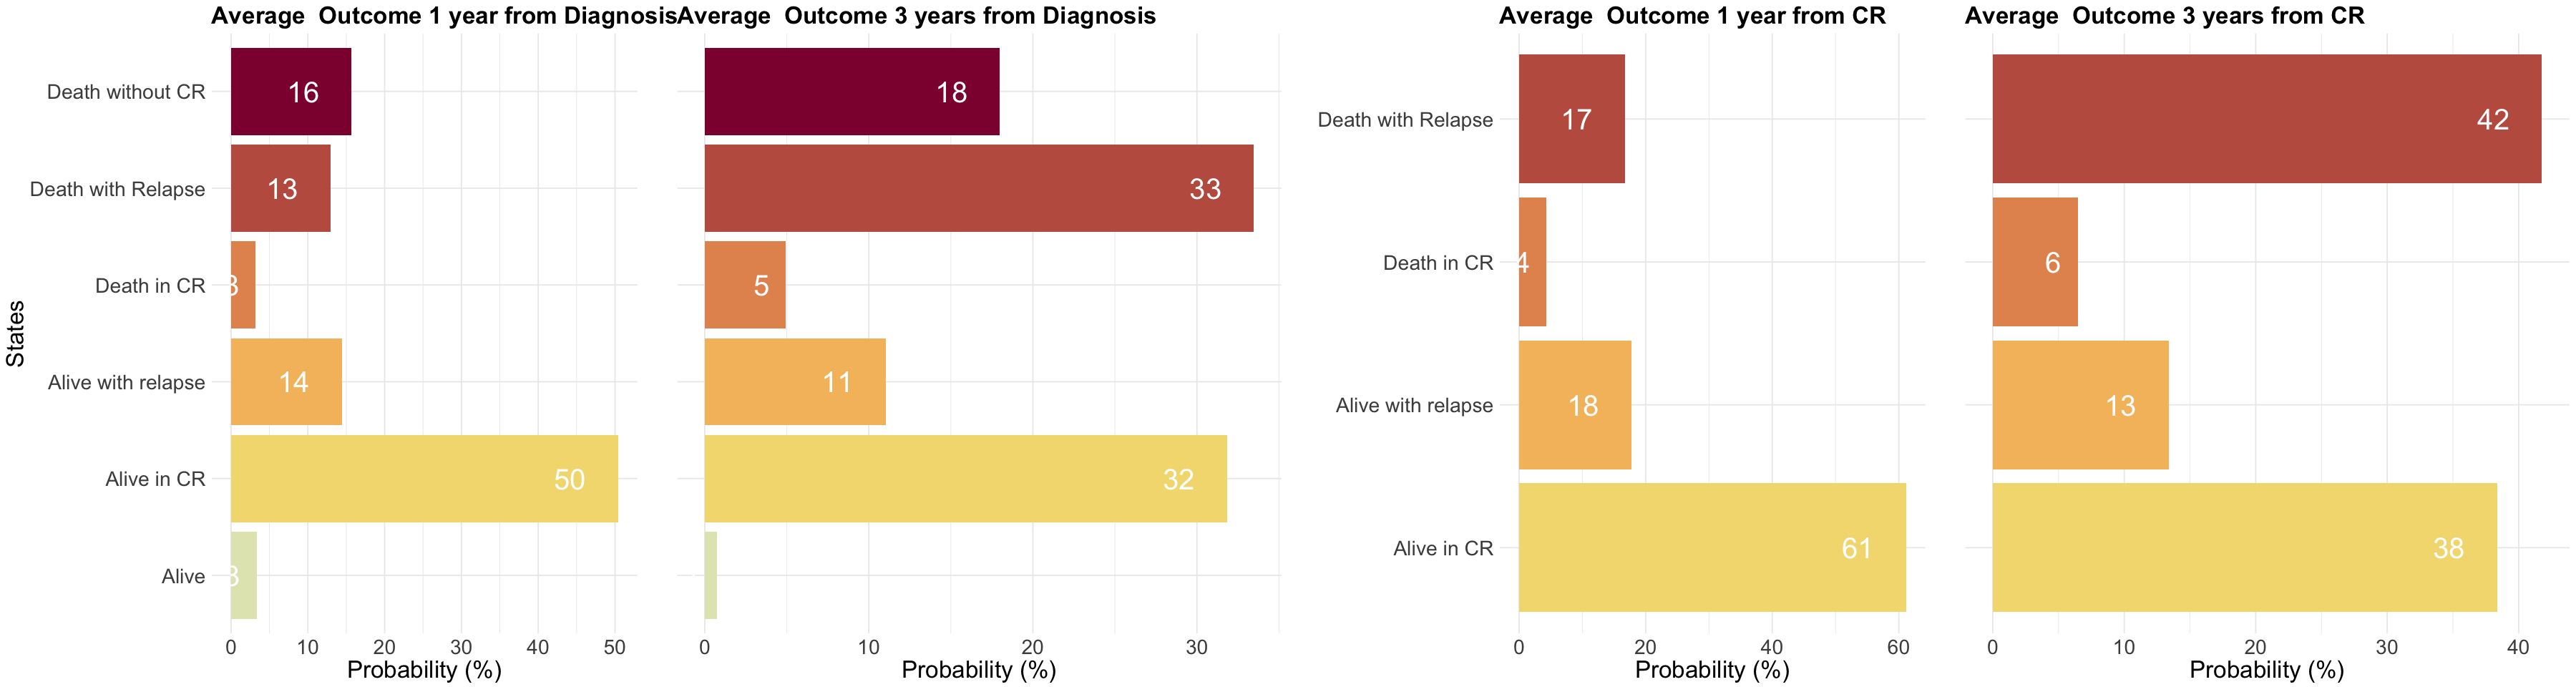

In [39]:
# pdf("Output_patient/Main_example2.pdf",width=30,height=7)
user_data_simplified <- classify_components(user_data,proposal=T)
covariates <- c(demo,clin,comp,"ITD","NEW_favorable","NEW_intermediate","NEW_adverse")
characteristics <- rownames(user_data_simplified[c(comp,"ITD","age"),,F][which(user_data_simplified[c(comp,"ITD","age"),"value"]>0),,F])
set_notebook_plot_size(30,8)
par(mfrow=c(1,2))


tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
tmp_data[nrow(tmp_data),covariates] <- as.numeric(user_data_simplified[covariates,])
patA <- tmp_data[rep(nrow(tmp_data),each=5),covariates]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data

patA <- expand.covs(patA, covariates, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

title_str1<- ifelse("age" %in% characteristics,paste("Patient ","-year-old and with",sep=as.character(user_data_simplified["age","value"])),"Patient with")
title_str2 <- toString(str_remove(characteristics[characteristics %in% c(comp,"ITD")],"full_component_"))
title_str <- paste(title_str1 , title_str2)

for (i in 1:2){
    plot(ptA,from=i, ord = c(1,2,3,4,5,6), main = title_str,cex.main=1.7,
    las = 1, xlab = ifelse(i==1,"Years from Diagnosis","Years from CR"), xlim = c(0, 10),cex.axis=2,cex=2,cex.main=3,cex.lab=2.4,
    type = "filled",ylab="", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}

ptrans1 <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA[[1]][ptA[[1]]$time>=1 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_1 <- ggplot(ptrans1,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+
  theme_minimal() + theme(axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold")) + ggtitle ("Patient Outcome 1 year from Diagnosis")

ptrans3 <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA[[1]][ptA[[1]]$time>=3 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_3 <-ggplot(ptrans3,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold"))+ ggtitle ("Patient Outcome 3 years from Diagnosis")


ptrans1_CR <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA[[2]][ptA[[2]]$time>=1 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_1 <- ggplot(ptrans1_CR,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+
  theme_minimal() + theme(axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold")) + ggtitle ("Patient Outcome 1 year from CR")

ptrans3_CR <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA[[2]][ptA[[2]]$time>=3 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_3 <-ggplot(ptrans3_CR,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold"))+ ggtitle ("Patient Outcome 3 years from CR")


grid.arrange(diagnosis_1,diagnosis_3,CR_1,CR_3,nrow=1)


# How average Proposal Patient is

set_notebook_plot_size(30,8)
par(mfrow=c(1,2))

patA_proposal <- tmp_data[rep(nrow(tmp_data),each=5),c("NEW_favorable","NEW_intermediate","NEW_adverse")]
patA_proposal$trans <- 1:5
attr(patA_proposal, "trans") <- tmat_data

patA_proposal <- expand.covs(patA_proposal, c("NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
patA_proposal$strata <- patA_proposal$trans
msfA_proposal <- msfit(cfull_proposal, patA_proposal, trans = tmat_data)

ptA_proposal <- probtrans(msfA_proposal, predt = 0)
ord <- c(1,2,3,4,5,6)
proposal_patient <- rownames(user_data_simplified[c("NEW_favorable","NEW_intermediate","NEW_adverse"),,F][which(user_data_simplified[c("NEW_favorable","NEW_intermediate","NEW_adverse"),"value"]>0),,F])

for (i in 1:2){
    plot(ptA_proposal,from=i, ord = c(1,2,3,4,5,6), main = paste("Average Patient in the Proposal Molecular Classification : ",proposal_patient),cex.main=1.7,
    las = 1, xlab = ifelse(i==1,"Years from Diagnosis","Years from CR"), xlim = c(0, 10),cex.axis=2,cex=2,cex.main=2,cex.lab=2.4,
    type = "filled",ylab="", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}

ptrans1_proposal <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA_proposal[[1]][ptA_proposal[[1]]$time>=1 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_1_proposal <- ggplot(ptrans1_proposal,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+
  theme_minimal() + theme(axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold")) +
ggtitle ("Average  Outcome 1 year from Diagnosis")

ptrans3_proposal <- data.frame(States=c("Alive","Alive in CR","Alive with relapse","Death in CR","Death with Relapse","Death without CR"),
                      proba=unlist(ptA_proposal[[1]][ptA_proposal[[1]]$time>=3 ,c("pstate1","pstate2","pstate3","pstate4","pstate5","pstate6")][1,]*100,use.names = F))
diagnosis_3_proposal <-ggplot(ptrans3_proposal,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols)+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold"))+
ggtitle ("Average  Outcome 3 years from Diagnosis")


ptrans1_CR_proposal <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA_proposal[[2]][ptA_proposal[[2]]$time>=1 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_1_proposal <- ggplot(ptrans1_CR_proposal,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+
  theme_minimal() + theme(axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold")) +
ggtitle ("Average  Outcome 1 year from CR")

ptrans3_CR_proposal <- data.frame(States=c("Alive in CR","Alive with relapse","Death in CR","Death with Relapse"),
                      proba=unlist(ptA_proposal[[2]][ptA_proposal[[2]]$time>=3 ,c("pstate2","pstate3","pstate4","pstate5")][1,]*100,use.names = F))
CR_3_proposal <-ggplot(ptrans3_CR_proposal,aes(x=States,y=proba)) + geom_bar(stat="identity", fill=statecols[c(2,3,4,5)])+
  geom_text(aes(label=round(proba,0)), vjust=0.5,hjust=2, color="white", size=8.5,face="bold")+ coord_flip()+ylab("Probability (%)")+xlab("")+theme_minimal() +
theme(axis.text.y=element_blank(),axis.ticks.y=element_blank(),axis.text=element_text(size=17),axis.title=element_text(size=20),plot.title=element_text(size=20,face="bold"))+ 
ggtitle ("Average  Outcome 3 years from CR")


grid.arrange(diagnosis_1_proposal,diagnosis_3_proposal,CR_1_proposal,CR_3_proposal,nrow=1)
# dev.off()

# 2) Forest Transition Plots

In [226]:
pdf("Output_patient/Page2_example2.pdf",width=30,height=10)
coef_data <- data.frame(summary(cfull)$coefficients)
set_notebook_plot_size(42,12)
p <- list()
count <- 1
for (trans in c(".1",".2",".3",".4",".5")){
    l <- coef_data[endsWith(rownames(coef_data),trans),]
    rownames(l) <- gsub('.{0,2}$', '', rownames(l))

    k <- merge(l,user_data_simplified,by=0)
    k["BetaZ"] <- k$coef * k$value
    k <- k %>%slice(match(covariates, Row.names))
    k <- k[(k$BetaZ!=0 & !is.na(k$BetaZ)),]
    k$Row.names <- str_remove(k$Row.names,"full_component_")
#     k <- k[order(k["BetaZ"],decreasing=T),]
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    xlab <- ifelse(trans==".1","Contributing Patient Covariates","")
    p[[trans]] <- ggplot(data = k,aes(x = factor(Row.names,level=rev(Row.names)),y= BetaZ)) + geom_bar(stat="identity",colour="blue",fill="steelblue") + coord_flip() + xlab(xlab) + ylab(expression(beta ~ Z)) + ggtitle(title) +
    theme_minimal() + theme(axis.title=element_text(size=30),axis.text.y=element_blank(),plot.title=element_text(size=20),axis.text.x=element_text(size=25)) 
    
    if(trans==".1"){
        p[[trans]] <- p[[trans]] + theme(axis.text.y=element_text(size=20))
    }
    #+ ifelse(trans==".1",theme(axis.text.x=element_text(size=20)),theme(axis.text.y=element_blank(),axis.ticks.y=element_blank()))
    #ifelse(trans==".1",theme(axis.text.x=element_blank()),theme(axis.text.x=element_text(size=20)))
    
}
do.call("grid.arrange",c(p,nrow=1))
dev.off()

pdf 
  2

# 3) Patient Centric Covariate Effects

In [91]:
pdf("Output_patient/Page3.pdf",width=20,height=10)
plot_forest
dev.off()

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


pdf 
  2